In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from ruamel.yaml import YAML
import schwimmbad
from argparse import ArgumentParser

import os
from os.path import join, basename, splitext
import sys
import shutil

import numpy as np
import time
import emcee
from sklearn.utils import check_random_state
import datetime
import h5py
import logging

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import pickle
import hickle
import seaborn as sns
from scipy import stats
import corner


from fit3bf.sampling import ObservableDistribution, TruncationDistribution
from fit3bf.utils import dict_hash
from fit3bf.observables import from_hdf5
from fit3bf import setup_rc_params
from fit3bf.constants import obs_names_tex_map
from fit3bf.utils import find_contour_levels
from fit3bf.graphs import darken_color, lighten_color

In [2]:
setup_rc_params()

# User Input

This notebook creates the gridded pdfs shown in Figs. 6 and 7. It must be run multiple times with the settings:
* Fig. 6(a): `cbar = 0`, `Q = 0.33`, and `fit_indiv = True` (this one takes a while to run due to increased grid density)
* Fig. 6(b): `cbar = 1`, `Q = 0.33`, and `fit_indiv = True`
* Fig. 7: `cbar = 1`, `Q = 0.33`, and `fit_indiv = False`

This requires emulators to be created for the 3-body LECs, not including the NN LECs. Ensure that the `object_directory` inside of the sampling parameters file corresponds to this set of emulators.

In [3]:
script_path = '../scripts/'
parameters_file = join(script_path, 'parameters/sampling_3bf_only.yaml')

# Truncation parameters
cbar = 1
Q = 0.33

# For file names
cbar_str = f"{cbar}".replace(".", "p")
Q_str = f"{Q}".replace(".", "p")

# Whether to fit sets of observables or individual ones
fit_indiv = False


obs_sets = [
    ["H3", "He4"],
    ["H3", "He4-radius"],
    ["H3", "H3-halflife"],
#     ["He4", "He4-radius"],
    ["He4", "H3-halflife"],
#     ["He4-radius", "H3-halflife"],
    ["H3", "He4", "He4-radius", "H3-halflife"],
]
obs_sets_indiv = [
    ["H3"],
    ["He4"],
    ["He4-radius"],
    ["H3-halflife"],
]


if fit_indiv and cbar == 0:
    # For 1 at a time, no truncation
    cd_vals = np.linspace(-2.1, 2.1, 1001)
    ce_vals = np.linspace(-0.75, 0.3, 1001)
elif fit_indiv and cbar > 0:
    # For 1 at a time, with truncation
    cd_vals = np.linspace(-2.1, 2.1, 401)
    ce_vals = np.linspace(-0.75, 0.3, 501)
elif not fit_indiv and cbar > 0:
    # For 2 at a time, with truncation
    cd_vals = np.linspace(-3, 3, 301)
    ce_vals = np.linspace(-0.9, 0.3, 401)
else:
    # For 2 at a time, without truncation. Not shown in paper.
    cd_vals = np.linspace(-3, 3, 1001)
    ce_vals = np.linspace(-0.9, 0.3, 1001)

# Compute PDF grids

This was basically copied from the training script.

In [4]:
if fit_indiv:
    log_pdf_map_var = log_pdf_indiv_map = {}
    pdf_map_var = pdf_indiv_map = {}
else:
    log_pdf_map_var = log_pdf_map = {}
    pdf_map_var = pdf_map = {}


obs_set_var = obs_sets
if fit_indiv:
    obs_set_var = obs_sets_indiv
for obs_lst in obs_set_var:
    print(obs_lst)

    yaml = YAML(typ="safe")
    with open(parameters_file, "r") as input_file:
        input_parameters = yaml.load(input_file)

    fit_obs = []
    fit_obs_str = ""

    for obs in input_parameters["observables"]:
        if obs_lst is not None:
            if obs in obs_lst:
                input_parameters["observables"][obs]["fit"] = True
            else:
                input_parameters["observables"][obs]["fit"] = False
        if input_parameters["observables"][obs]["fit"]:
            fit_obs.append(obs)
            fit_obs_str += obs + "-"
    fit_obs_str = fit_obs_str[:-1]
    print(fit_obs, fit_obs_str)

    input_hash = dict_hash(input_parameters)
    param_basename = splitext(basename(parameters_file))[0]
    now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


    ####################################################################
    # Set up ObservableDistribution object, which holds
    # all observable classes to make predictions, and the data
    # necessary to fit the parameters
    ####################################################################
    data = []
    data_stdv = []
    observables = []

    object_directory = join(script_path, input_parameters["mcmc"]["object_directory"])
    observable_names = []
    for obs_name, obs in input_parameters["observables"].items():
        if obs["fit"]:
            data.append(obs["experiment_central_value"])
            data_stdv.append(obs["experiment_standard_deviation"])
            observable_names.append(obs_name)
            observables.append(from_hdf5(join(object_directory, f"{obs_name}.h5")))
            # with open(join(object_directory, obs_name + ".pickle"), "rb") as file:
            #     observables.append(pickle.load(file))
    cov_expt = np.diag(data_stdv) ** 2

    hyp = input_parameters["hyperparameters"]
    mcmc = input_parameters["mcmc"]
    output_directory = join(object_directory, fit_obs_str + "_" + now)
    output_file = join(output_directory, mcmc["output_file"])
    parameter_names = mcmc["parameter_names"]
    post_parameter_names = mcmc["posterior_parameter_names"]
    use_post_parameters = (post_parameter_names is not None) and (len(post_parameter_names) != 0)

    if use_post_parameters:
        posterior_lecs_indices = np.where(np.isin(parameter_names, post_parameter_names))[0]
    else:
        posterior_lecs_indices = None

    if not use_post_parameters:
        loc_post_lecs = None
        cov_post_lecs = None
    else:
        with open(hyp["mean_file"], "r") as input_file:
            post_param_map = yaml.load(input_file)
            loc_post_lecs = np.array([post_param_map[name] for name in post_parameter_names])
        cov_post_lecs = np.load(hyp["posterior_parameters_covariance_file"], allow_pickle=False)

    y_ref = hyp["y_ref"]
    truncation_ignore_observables = hyp["truncation_ignore_observables"]
    trunc_dist_obs_mask = np.ones(len(observable_names), dtype=bool)
    if y_ref == "expt":
        y_ref = np.array(np.abs(data))
        if truncation_ignore_observables is not None:
            trunc_dist_obs_mask = ~np.isin(observable_names, truncation_ignore_observables)
            print(y_ref, trunc_dist_obs_mask)
            y_ref = y_ref[trunc_dist_obs_mask]
    else:
        y_ref = np.array(y_ref)

    y_lower = []
    for i, obs in enumerate(observable_names):
        if trunc_dist_obs_mask[i]:
            y_lower.append(hyp["y_lower"][obs])
    y_lower = np.asarray(y_lower)

    trunc_dist = TruncationDistribution(
        df_0=hyp["cbar"]["degrees_of_freedom"],
        scale_0=hyp["cbar"]["scale"],
        a_0=hyp["Q"]["a"],
        b_0=hyp["Q"]["b"],
        y_lower=y_lower,
        orders_lower=np.atleast_1d(hyp["orders_lower"]),
        ignore_orders=hyp["ignore_orders"],
        y_ref=y_ref,
        update_prior=True,
        deg_quadrature=hyp["deg_quadrature"]
    )


    # This will do most of the work behind the scenes
    obs_dist = ObservableDistribution(
        data=data,
        observables=observables,
        order=hyp["EFT_order"],
        cov_expt=cov_expt,
        mean_posterior_lecs=loc_post_lecs,
        cov_posterior_lecs=cov_post_lecs,
        lecs_prior_std=hyp["prior_standard_deviation"],
        trunc_dist=trunc_dist,
        trunc_ignore_observables=truncation_ignore_observables,
        cbar=hyp["cbar"]["fixed_value"],
        Q=hyp["Q"]["fixed_value"],
        return_predictions=mcmc["store_predictions"],
        output_file=output_file,
        observable_names=observable_names,
        parameter_names=mcmc["parameter_names"],
        compute_gradients=hyp["use_gradients"],
        posterior_lecs_indices=posterior_lecs_indices,
    )
    
    
    log_pdf_mat = np.zeros((len(cd_vals), len(ce_vals)))
    print(log_pdf_mat.shape, log_pdf_mat.size)
    # for i, lecs in enumerate(lec_vals):
    #     if i % 1000 == 0:
    #         print(i)
    #     log_pdf[i] = obs_dist.logpdf(lecs, cbar=0, Q=0.33, return_predictions=False)
    nn = 0
    for i, cd in enumerate(cd_vals):
        for j, ce in enumerate(ce_vals):
            nn += 1
            if nn % 1000 == 0:
#                 print(nn)
                pass
            log_pdf_mat[i, j] = obs_dist.logpdf(np.array([cd, ce]), cbar=cbar, Q=Q, return_predictions=False)
    log_pdf_mat = log_pdf_mat - np.max(log_pdf_mat)
    pdf_mat = np.exp(log_pdf_mat)
    pdf_mat = pdf_mat / np.trapz(np.trapz(pdf_mat, ce_vals), cd_vals)
    
    log_pdf_map_var[tuple(obs_lst)] = log_pdf_mat
    pdf_map_var[tuple(obs_lst)] = pdf_mat

['H3', 'He4']
['H3', 'He4'] H3-He4
[ 8.482 28.296] [ True  True]
The ignored observables are not all in the list of observable names.
trunc_ignore_observables = ['H3-halflife']
Bad indices: [ True]
observable_names = ['H3', 'He4']
(301, 401) 120701
['H3', 'He4-radius']
['H3', 'He4-radius'] H3-He4-radius
[8.482  1.4552] [ True  True]
The ignored observables are not all in the list of observable names.
trunc_ignore_observables = ['H3-halflife']
Bad indices: [ True]
observable_names = ['H3', 'He4-radius']
(301, 401) 120701
['H3', 'H3-halflife']
['H3', 'H3-halflife'] H3-H3-halflife
[   8.482 1129.6  ] [ True False]
(301, 401) 120701
['He4', 'H3-halflife']
['He4', 'H3-halflife'] He4-H3-halflife
[  28.296 1129.6  ] [ True False]
(301, 401) 120701
['H3', 'He4', 'He4-radius', 'H3-halflife']
['H3', 'He4', 'He4-radius', 'H3-halflife'] H3-He4-He4-radius-H3-halflife
[   8.482    28.296     1.4552 1129.6   ] [ True  True  True False]
(301, 401) 120701


Dump the gridded pdfs just in case you want to access them later.

In [14]:
out_map = pdf_map_var.copy()
out_map["cD"] = cd_vals
out_map["cE"] = ce_vals
out_map["cbar"] = cbar
out_map["Q"] = Q

if fit_indiv:
    num_obs_str = "single"
else:
    num_obs_str = "multi"

with open(f"{num_obs_str}_obs_fit_grid_cbar-{cbar_str}_Q-{Q_str}_new.h5", 'w') as file:
    hickle.dump(out_map, file)

This is how to load it back in:

In [124]:
# with open(f"{num_obs_str}_obs_fit_grid_cbar-{cbar_str}_Q-{Q_str}_new.h5", 'r') as file:
#     out_map = hickle.load(file)
# pdf_map_var = out_map
# if fit_indiv:
#     pdf_indiv_map = pdf_map_var
# else:
#     pdf_map = pdf_map_var
# cd_vals = out_map['cD']
# ce_vals = out_map['cE']

# Setup Plots

Choose the amount of probability mass around which to draw a contour. Generally we will show 1$\sigma$ bands (`contour_masses`), but we also create `contour_masses2` that goes to 2$\sigma$ for bands that are already very thin (the `He4` bands when `cbar = 0`) simply to make it more visible. These are based on 2d Gaussian masses that correspond to 1 and 2 $\sigma$.

In [18]:
contour_masses = np.array([0] + [1-np.exp(-0.5*r**2) for r in [1]])
contour_masses2 = np.array([0] + [1-np.exp(-0.5*r**2) for r in [1, 2]])

In [127]:
contour_masses

array([0.        , 0.39346934])

In [15]:
c_H3_dark = sns.color_palette("deep")[2]
c_H3_light = sns.color_palette("pastel")[2]

c_He4_dark = sns.color_palette("muted")[0]
c_He4_light = sns.color_palette("pastel")[0]

c_He4r_dark = sns.color_palette("muted")[1]
c_He4r_light = darken_color(sns.color_palette("pastel")[1], amount=0.95)

c_H3ft_dark = 'k'
c_H3ft_light = 'lightgray'

## Individual PDFs Plot

Set up the plotting parameters for the different truncation settings.

In [125]:
if fit_indiv:
    mpl.rcParams["hatch.color"] = c_He4_dark

    if cbar == 0:
        obs_contour_kwargs = {
            'H3': {
                "levels": find_contour_levels(pdf_indiv_map[("H3",)], levels=contour_masses),
                "colors": [c_H3_light],
                'linestyles': None,
                "linewidths": [1],
                "zorder": 2,
                "contour_kwargs": {"colors": [c_H3_dark], "linewidths": [1],}

            },
            'He4': {
                "levels": find_contour_levels(pdf_indiv_map[("He4",)], levels=contour_masses2),
                "colors": [c_He4_light],
                "linewidths": [1],
                "zorder": 3,
                "contour_kwargs": {"colors": [c_He4_dark], "linewidths": [1],}
            },
            'He4-radius': {
                "colors": [c_He4r_light],
                "levels": find_contour_levels(pdf_indiv_map[("He4-radius",)], levels=contour_masses),
                "zorder": 0,
                "contour_kwargs": {"colors": [c_He4r_dark], "linewidths": [1],}
            },
            'H3-halflife':{
                'alpha': 0.3,
                "levels": find_contour_levels(pdf_indiv_map[("H3-halflife",)], levels=contour_masses),
                "zorder": 1,
                "colors": c_H3ft_light,
                "contour_kwargs": {"colors": [c_H3ft_dark], "linewidths": [1], "alpha": 1}
            },
        }

        obs_contour_is_filled = {
            'H3': 'both',
            'He4': 'both',
            'He4-radius': 'both',
            'H3-halflife': 'both',
        }
        obs_contour_text_kwargs = {
            'H3': {"x": 0.93, "y": 0.65, "c": c_H3_dark, "ha": "right", "va": "top"},
            'He4': {"x": 0.93, "y": 0.915, "c": c_He4_dark, "ha": "right", "va": "top"},
            'He4-radius': {"x": 0.05, "y": 0.05, "c": c_He4r_dark, "ha": "left", "va": "bottom"},
            'H3-halflife': {"x": 0.615, "y": 0.05, "c": c_H3ft_dark, "ha": "left", "va": "bottom"},
        }
    else:
        obs_contour_kwargs = {
            'H3': {
                "levels": find_contour_levels(pdf_indiv_map[("H3",)], levels=contour_masses),
                "colors": [c_H3_light],
                'linestyles': None,
                "linewidths": [1],
                "zorder": 2,
                "contour_kwargs": {"colors": [c_H3_dark], "linewidths": [1],}
            },
            'He4': {
                "levels": find_contour_levels(pdf_indiv_map[("He4",)], levels=contour_masses),
                "colors": [c_He4_light],
                "edgecolor": [c_He4_light],
                "alpha": 0.3,
                "hatches": ["\\\\"],
                "linewidths": [1],
                "zorder": 3,
                "contour_kwargs": {"colors": [c_He4_dark], "linewidths": [1], "alpha": 1}
            },
            'He4-radius': {
                "colors": [c_He4r_light],
                "levels": find_contour_levels(pdf_indiv_map[("He4-radius",)], levels=contour_masses),
                "zorder": 0,
                "contour_kwargs": {"colors": [c_He4r_dark], "linewidths": [1],}
            },
            'H3-halflife':{
                'alpha': 0.3,
                "levels": find_contour_levels(pdf_indiv_map[("H3-halflife",)], levels=contour_masses),
                "zorder": 1,
                "colors": c_H3ft_light,
                "contour_kwargs": {"colors": [c_H3ft_dark], "linewidths": [1], 'alpha': 1}
            },
        }

        obs_contour_is_filled = {
            'H3': 'both',
            'He4': 'both',
            'He4-radius': 'both',
            'H3-halflife': "both",
        }
        obs_contour_text_kwargs = {
            'H3': {"x": 0.93, "y": 0.65, "c": c_H3_dark, "ha": "right", "va": "top"},
            'He4': {"x": 0.93, "y": 0.915, "c": c_He4_dark, "ha": "right", "va": "top"},
            'He4-radius': {"x": 0.05, "y": 0.05, "c": c_He4r_dark, "ha": "left", "va": "bottom"},
            'H3-halflife': {"x": 0.615, "y": 0.05, "c": c_H3ft_dark, "ha": "left", "va": "bottom"},
        }


    # =============================================================
    
    
    fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4), sharex=True, sharey=True)

    for i, obs_lst in enumerate(obs_sets_indiv):
        pdf_i = pdf_indiv_map[tuple(obs_lst)]
        obs_lst_i = obs_lst[0]
    #     ax = axes.ravel()[i]

        kw = obs_contour_kwargs[obs_lst_i]
        if obs_contour_is_filled[obs_lst[0]] == 'both':
            ax.contourf(
                cd_vals, ce_vals, pdf_i.T, **kw,
            )
            kw_contour = kw.copy()
            if "contour_kwargs" in kw_contour:
                kw_contour.update(kw["contour_kwargs"])
            ax.contour(
                cd_vals, ce_vals, pdf_i.T, **kw_contour,
            )
        elif obs_contour_is_filled[obs_lst[0]] is True:
            ax.contourf(
                cd_vals, ce_vals, pdf_i.T, **kw
            )
        else:
            ax.contour(
                cd_vals, ce_vals, pdf_i.T, **kw,
    #             label=obs_names_tex_map[obs_lst_i]
            )
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
        ax.tick_params(right=True, top=True, which='both')
        if i == 0:
            ax.set_ylabel(r"$c_E$")
        ax.set_xlabel(r"$c_D$")
    #     ax.text(
    #         0.05, 0.95, f"{obs_names_tex_map[obs_lst[0]]}",
    #         transform=ax.transAxes,
    #         ma='left', ha='left', va='top',
    #         bbox=dict(boxstyle="round", facecolor="w")
    #     )
        ax.text(
            s=f"{obs_names_tex_map[obs_lst[0]]}",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", facecolor="w"),
            **obs_contour_text_kwargs[obs_lst_i]
        )

    if cbar != 0:
        desc_str = (
            "With EFT Error\n"
            fr"$\bar c = {{{cbar}}}$,~~~" #"\n"
            fr"$Q = {{{Q}}}$"
        )
    else:
        desc_str = "No EFT Error"
    ax.text(
        x=0.05, y=0.95,
        s=desc_str,
        transform=ax.transAxes,
        ma='left', ha='left', va='top',
        bbox=dict(boxstyle="round", facecolor="w"),
    );
    # ax.legend()
    fig.savefig(f"single_obs_fit_grid_posteriors_cbar-{cbar_str}_Q-{Q_str}", dpi=700)

In [ ]:
if fit_indiv:
    print("The individual plots have completed. The rest of the notebook is only for fit_indiv = False.")
    assert False

## Joint PDF Plots

Although not shown in the paper, it is interesting to fit a Gaussian to the full 4-observable fit to see what its mean and covariance matrix are. Because `cbar` and `Q` are fixed, and the problem is approximately linear, a Gaussian is a good approximation.

In [19]:
obs_lst_all = tuple(["H3", "He4", "He4-radius", "H3-halflife"])
levels_all = find_contour_levels(pdf_map[obs_lst_all], levels=contour_masses)

In [34]:
c_mat = np.zeros((len(cd_vals), len(ce_vals), 2))
c_mat[..., 0] = cd_vals[:, None]
c_mat[..., 1] = ce_vals[None, :]

In [69]:
from fit3bf.graphs import unmap_rho, map_rho, confidence_ellipse_mean_cov

In [64]:
def unpack_normal_args(args):
    mu = args[:2]
    sd = np.exp(args[2:4])
    rho = unmap_rho(args[4])
    
    cov = np.eye(2)
    cov[np.tril_indices(2, -1)] = rho
    cov[np.triu_indices(2, +1)] = rho
    cov = sd * sd[:, None] * cov
    return mu, cov


def pdf_discrepancy(args, X, pdf):
    mu, cov = unpack_normal_args(args)
    try:
        norm_pdf = stats.multivariate_normal(mean=mu, cov=cov).pdf(X)
    except np.linalg.LinAlgError as e:
        print(args)
        print(mu, cov)
        raise e
    return np.sum((pdf - norm_pdf)**2)

def fit_mv_normal_pdf(X, pdf, mu0, cov0):
    from scipy import optimize
    args = np.zeros(5)
    args[:2] = mu0
    args[2:4] = np.log(np.sqrt(np.diag(cov0)))
    args[4] = map_rho(cov0[1, 0] / np.sqrt(cov0[0, 0]*cov0[1,1]))
    print(args)
    
    
    out = optimize.fmin(
        pdf_discrepancy, x0=args, args=(X, pdf)
    )
    mu, cov = unpack_normal_args(out)
    return mu, cov

In [52]:
max_idx = np.unravel_index(np.argmax(pdf_map[obs_lst_all]), pdf_map[obs_lst_all].shape)

In [48]:
mu_mean_all = c_mat[max_idx]

In [68]:
mu_mean_all

array([-0.02 , -0.195])

In [49]:
cov_mean_all = np.eye(2)
cov_mean_all[0, 0] = 0.5**2
cov_mean_all[1, 1] = 0.5**2
cov_mean_all[1, 0] = cov_mean_all[0, 1] = 0.5**2 * 0.8

In [65]:
mu_fit_all, cov_fit_all = fit_mv_normal_pdf(c_mat, pdf_map[obs_lst_all], mu0=mu_mean_all, cov0=cov_mean_all)

[-0.02       -0.195      -0.69314718 -0.69314718  3.07768354]
Optimization terminated successfully.
         Current function value: 125.213223
         Iterations: 351
         Function evaluations: 577


In [66]:
mu_fit_all

array([-0.01381504, -0.19443024])

In [67]:
cov_fit_all

array([[0.17096303, 0.02975308],
       [0.02975308, 0.00563931]])

Joint fits: 3H & 4He energies; 3H energy & 4He radius; 3H energy & fT_{1/2}; 4He energy & fT_{1/2}

<ipython-input-81-3771d6338b66>:45: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(h_pad=0.4, w_pad=0.4, pad=0.2)


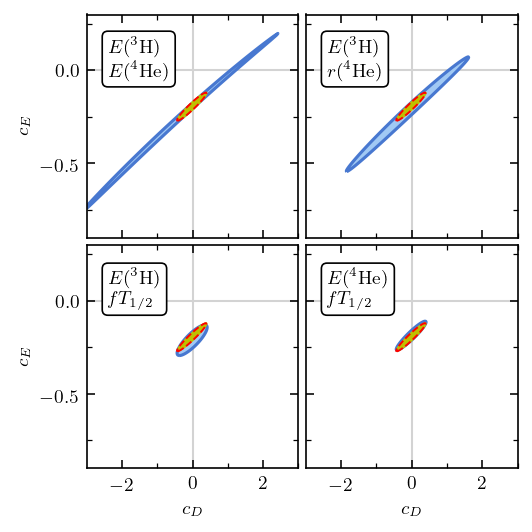

In [81]:
fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.4), sharex=True, sharey=True)

c_two_dark = sns.color_palette("muted")[0]
c_two_light = sns.color_palette("pastel")[0]

for i, obs_lst in enumerate([
    ["H3", "He4"],
    ["H3", "He4-radius"],
    ["H3", "H3-halflife"],
    ["He4", "H3-halflife"]
]):
    obs_lst_i = tuple(obs_lst)
    pdf_i = pdf_map[obs_lst_i]
    levels_i = find_contour_levels(pdf_i, levels=contour_masses)
    ax = axes.ravel()[i]
    ax.contourf(cd_vals, ce_vals, pdf_i.T, levels=levels_i, colors=[c_two_light], zorder=1)
    ax.contour(cd_vals, ce_vals, pdf_i.T, levels=levels_i, colors=[c_two_dark], zorder=1)
    
    ax.contour(
        cd_vals, ce_vals, pdf_map[obs_lst_all].T,
        levels=levels_all, colors=['r'],
        linestyles=["dashed"],
        linewidths=[0.9],
        zorder=2,
    )
    
    # Uncomment this line if you want to see the Gaussian fit:
    # confidence_ellipse_mean_cov(mu_fit_all, cov_fit_all, ax=ax, n_std=1, facecolor='y', edgecolor='y', zorder=1.3)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(right=True, top=True, which='both')
    if i % 2 == 0:
        ax.set_ylabel(r"$c_E$")
    if i > 1:
        ax.set_xlabel(r"$c_D$")
    ax.text(
        0.1, 0.9, f"{obs_names_tex_map[obs_lst[0]]}\n{obs_names_tex_map[obs_lst[1]]}",
        transform=ax.transAxes,
        ma='left', ha='left', va='top',
        bbox=dict(boxstyle="round", facecolor="w")
    )
#     ax.set_xlim(-2.5, 2.5)
    ax.axhline(0, 0, 1, c='lightgrey', lw=1, zorder=0)
    ax.axvline(0, 0, 1, c='lightgrey', lw=1, zorder=0)
fig.tight_layout(h_pad=0.4, w_pad=0.4, pad=0.2)
fig.savefig(f"double_obs_fit_grid_posteriors_cbar-{cbar_str}_Q-{Q_str}", dpi=700)

# OLD STUFF BELOW

---

In [7]:
assert False

AssertionError: 

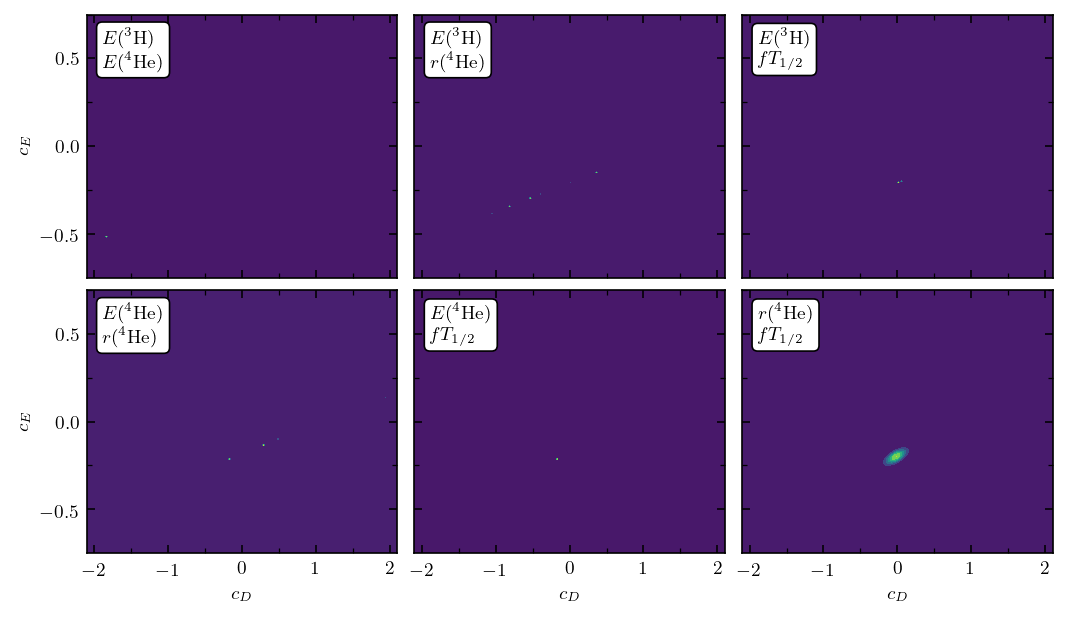

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(7, 4), sharex=True, sharey=True)

for i, obs_lst in enumerate(obs_sets):
    pdf_i = pdf_map[tuple(obs_lst)]
    ax = axes.ravel()[i]
    ax.contourf(cd_vals, ce_vals, pdf_i.T)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(right=True, top=True, which='both')
    if i % 3 == 0:
        ax.set_ylabel(r"$c_E$")
    if i > 2:
        ax.set_xlabel(r"$c_D$")
    ax.text(
        0.05, 0.95, f"{obs_names_tex_map[obs_lst[0]]}\n{obs_names_tex_map[obs_lst[1]]}",
        transform=ax.transAxes,
        ma='left', ha='left', va='top',
        bbox=dict(boxstyle="round", facecolor="w")
    )

In [ ]:
def cartesian(*arrays):
    """Makes the Cartesian product of arrays.

    Parameters
    ----------
    *arrays : array group, shapes = (N_1,), (N_2,), ..., (N_p,)
            1D arrays where earlier arrays loop more slowly than later ones

    Returns
    -------
    array, shape = (N_1 * N_2 * ... * N_p, p)
        The cartesian product
    """
    N = len(arrays)
    return np.stack(np.meshgrid(*arrays, indexing='ij'), -1).reshape(-1, N)

In [ ]:
fit_obs_str

In [ ]:


# # cd_vals = np.linspace(-1.5, -0.5, 101)
# # ce_vals = np.linspace(-0.5, -0.2, 201)
# lec_vals = cartesian(cd_vals, ce_vals)

# # log_pdf = np.zeros(len(lec_vals))
# log_pdf_mat = np.zeros((len(cd_vals), len(ce_vals)))
# print(log_pdf_mat.shape, log_pdf_mat.size)
# # for i, lecs in enumerate(lec_vals):
# #     if i % 1000 == 0:
# #         print(i)
# #     log_pdf[i] = obs_dist.logpdf(lecs, cbar=0, Q=0.33, return_predictions=False)
# nn = 0
# for i, cd in enumerate(cd_vals):
#     for j, ce in enumerate(ce_vals):
#         nn += 1
#         if nn % 1000 == 0:
#             print(nn)
#         log_pdf_mat[i, j] = obs_dist.logpdf(np.array([cd, ce]), cbar=0, Q=0.33, return_predictions=False)
# log_pdf_mat = log_pdf_mat - np.max(log_pdf_mat)
# pdf_mat = np.exp(log_pdf_mat)
# pdf_mat = pdf_mat / np.trapz(np.trapz(pdf_mat, ce_vals), cd_vals)

In [ ]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax.contourf(ce_vals, cd_vals, pdf_mat)
ax.set_xlabel(r"$c_E$")
ax.set_ylabel(r"$c_D$")
ax.set_title(f"pr($c_D, c_E$) -- Only Expt. Errors, {fit_obs_str}")

In [ ]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax.contourf(ce_vals, cd_vals, pdf_mat)
ax.set_xlabel(r"$c_E$")
ax.set_ylabel(r"$c_D$")
ax.set_title("pr($c_D, c_E$) -- Only Expt. Errors")

In [ ]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax.contourf(ce_vals, cd_vals, pdf_mat)
ax.set_xlabel(r"$c_E$")
ax.set_ylabel(r"$c_D$")
ax.set_title("pr($c_D, c_E$)")

In [ ]:
plt.contourf(ce_vals, cd_vals, np.exp(log_pdf_mat))